<a href="https://colab.research.google.com/github/davidpardigol/MusicTransformer/blob/main/Super_Piano_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Piano 3: Google Music Transformer
## Generating Music with Long-Term structure
### Based on 2019 ICLR paper by Cheng-Zhi Anna Huang, Google Brain and Damon Gwinn's code/repo https://github.com/gwinndr/MusicTransformer-Pytorch

Huge thanks go out to the following people who contributed the code/repos used in this colab. Additional contributors are listed in the code as well.

1) Kevin-Yang https://github.com/jason9693/midi-neural-processor

2) gudgud96 for fixing Kevin's MIDI Encoder properly https://github.com/gudgud96

2) jinyi12, Zac Koh, Akamight, Zhang https://github.com/COMP6248-Reproducability-Challenge/music-transformer-comp6248

Thank you so much for your hard work and for sharing it with the world :)


###Setup Environment and Dependencies. Check GPU.

In [1]:
#@title Check if GPU (driver) is avaiiable (you do not want to run this on CPU, trust me)
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sat Jan 18 07:42:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  7

In [2]:
#@title Clone/Install all dependencies
!git clone https://github.com/asigalov61/midi-neural-processor
!git clone https://github.com/asigalov61/MusicTransformer-Pytorch
!pip install tqdm
!pip install progress
!pip install pretty-midi
!pip install pypianoroll
!pip install matplotlib
!pip install librosa
!pip install scipy
!pip install pillow
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio
!pip install mir_eval
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/font.sf2

Cloning into 'midi-neural-processor'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26 (from 1)
Receiving objects: 100% (26/26), 8.00 KiB | 8.00 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Cloning into 'MusicTransformer-Pytorch'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 385 (delta 123), reused 107 (delta 107), pack-reused 223 (from 1)
Receiving objects: 100% (385/385), 101.03 KiB | 744.00 KiB/s, done.
Resolving deltas: 100% (204/204), done.
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9613 sha256=4822b42acbbd700aee8d1b6c0fb2ff5a60b7cff5f2f34690f921ce44aaf0191a
  Stored in directory: /root/.cache/pip/wheels/b5/b9/86/f1bcc2a1de592673c4192d9459c0da1100d70212f38b6bd2a4
Successfully built progress
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB

In [4]:
#@title Import all needed modules
import numpy as np
import pickle
import os
import sys
import math
import random
# For plotting
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
#%matplotlib inline
#matplotlib.get_backend()
#import mir_eval.display
import librosa
import librosa.display
# For rendering output audio
import pretty_midi
from midi2audio import FluidSynth
from google.colab import output
from IPython.display import display, Javascript, HTML, Audio

In [ ]:
#@title (Optional) Pre-trained models download (2 models trained for 100 epochs to 1.968 FLoss and 0.420 acc)
!mkdir /content/MusicTransformer-Pytorch/rpr
!mkdir /content/MusicTransformer-Pytorch/rpr/results
%cd /content/MusicTransformer-Pytorch/rpr/results
!wget 'https://superpiano.s3-us-west-1.amazonaws.com/SuperPiano3models.zip'
!unzip SuperPiano3models.zip
%cd /content/MusicTransformer-Pytorch/

#Please note that you MUST DOWNLOAD AND PROCESS ONE OF THE DATASETS TO TRAIN OR TO USE PRE-TRAINED MODEL as it primes the model from DATASET files.

#Option 1: MAESTRO DataSet

In [5]:
#@title Download Google Magenta MAESTRO v.2.0.0 Piano MIDI Dataset (~1300 MIDIs)
%cd /content/MusicTransformer-Pytorch/dataset/
!wget 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'
!unzip maestro-v2.0.0-midi.zip
%cd /content/MusicTransformer-Pytorch/

/content/MusicTransformer-Pytorch/dataset
--2025-01-18 07:50:28--  https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59243107 (56M) [application/zip]
Saving to: ‘maestro-v2.0.0-midi.zip’

maestro-v2.0.0-midi 100%[===================>]  56.50M   139MB/s    in 0.4s    

2025-01-18 07:50:29 (139 MB/s) - ‘maestro-v2.0.0-midi.zip’ saved [59243107/59243107]

Archive:  maestro-v2.0.0-midi.zip
   creating: maestro-v2.0.0/
  inflating: maestro-v2.0.0/maestro-v2.0.0.csv  
   creating: maestro-v2.0.0/2008/
  inflating: maestro-v2.0.0/2008/MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--1.midi  
  inflating: maestro-v2.0.0/2008/MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_0

In [6]:
#@title Prepare directory sctructure and MIDI processor
%cd /content/
!mv midi-neural-processor midi_processor
%cd /content/MusicTransformer-Pytorch/

/content
/content/MusicTransformer-Pytorch


In [7]:
#@title Process MAESTRO MIDI DataSet
!python3 preprocess_midi.py '/content/MusicTransformer-Pytorch/dataset/maestro-v2.0.0'

Preprocessing midi files and saving to ./dataset/e_piano
Found 1282 pieces
Preprocessing...
50 / 1282
100 / 1282
150 / 1282
200 / 1282
250 / 1282
300 / 1282
350 / 1282
400 / 1282
450 / 1282
500 / 1282
550 / 1282
600 / 1282
650 / 1282
700 / 1282
750 / 1282
800 / 1282
850 / 1282
900 / 1282
950 / 1282
1000 / 1282
1050 / 1282
1100 / 1282
1150 / 1282
1200 / 1282
1250 / 1282
Num Train: 967
Num Val: 137
Num Test: 178
Done!



#Option 2: Your own Custom MIDI DataSet

In [ ]:
#@title Create directory structure for the DataSet and prep MIDI processor

!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/train'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/test'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/val'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

%cd /content/
!mv midi-neural-processor midi_processor
%cd /content/MusicTransformer-Pytorch/

In [ ]:
#@title Upload your custom MIDI DataSet to created "dataset/e_piano/custom_midis" folder through this cell or manually through any other means. You can also use ready-to-use DataSets below
from google.colab import files
%cd '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
#@title (The Best Choice/Works best stand-alone) Super Piano 2 Original 2500 MIDIs of Piano Music
%cd /content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis
!wget 'https://github.com/asigalov61/SuperPiano/raw/master/Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip'
!unzip -j 'Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip'
!rm Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip

In [ ]:
#@title (Second Best Choice/Works best stand-alone) Alex Piano Only Original 450 MIDIs
%cd /content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis
!wget 'https://github.com/asigalov61/AlexMIDIDataSet/raw/master/AlexMIDIDataSet-CC-BY-NC-SA-Piano-Only.zip'
!unzip -j 'AlexMIDIDataSet-CC-BY-NC-SA-Piano-Only.zip'
!rm AlexMIDIDataSet-CC-BY-NC-SA-All-Drafts-Piano-Only.zip

For now, we are going to split the dataset by random into "test"/"val" dirs which is not ideal. So feel free to modify the code to your liking to achieve better training results with this implementation.

In [ ]:
#@title Process your custom MIDI DataSet :)
%cd /content/MusicTransformer-Pytorch
from processor import encode_midi

import os
import random



%cd '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

custom_MIDI_DataSet_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

train_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/train' # split_type = 0
test_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/test' # split_type = 1
val_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/val' # split_type = 2

total_count = 0
train_count = 0
val_count   = 0
test_count  = 0

f_ext = '.pickle'
fileList = os.listdir(custom_MIDI_DataSet_dir)
for file in fileList:
     # we gonna split by a random selection for now

    split = random.randint(1, 2)
    if (split == 0):
         o_file = os.path.join(train_dir, file+f_ext)
         train_count += 1

    elif (split == 2):
         o_file0 = os.path.join(train_dir, file+f_ext)
         train_count += 1
         o_file = os.path.join(val_dir, file+f_ext)
         val_count += 1

    elif (split == 1):
         o_file0 = os.path.join(train_dir, file+f_ext)
         train_count += 1
         o_file = os.path.join(test_dir, file+f_ext)
         test_count += 1
    try:
      prepped = encode_midi(file)
      o_stream = open(o_file0, "wb")
      pickle.dump(prepped, o_stream)
      o_stream.close()

      prepped = encode_midi(file)
      o_stream = open(o_file, "wb")
      pickle.dump(prepped, o_stream)
      o_stream.close()

      print(file)
      print(o_file)
      print('Coverted!')
    except KeyboardInterrupt:
      raise
    except:
      print('Bad file. Skipping...')

print('Done')
print("Num Train:", train_count)
print("Num Val:", val_count)
print("Num Test:", test_count)
print("Total Count:", train_count)

%cd /content/MusicTransformer-Pytorch

#Train the Model

In [ ]:
#@title Activate Tensorboard Graphs/Stats to monitor/evaluate model perfomance during and after training runs
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime, os
%tensorboard --logdir /content/MusicTransformer-Pytorch/rpr

In [10]:
#@title Start to Train the Model
batch_size = 2 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 50 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
!python3 train.py -output_dir rpr --rpr -batch_size=$batch_size -epochs=$number_of_training_epochs -max_sequence=$maximum_output_MIDI_sequence #-n_layers -num_heads -d_model -dim_feedforward

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 38  Batch 48 / 484
LR: 0.0003315669547886407
Train loss: 3.0045318603515625

Time (s): 0.21296119689941406

Epoch 38  Batch 49 / 484
LR: 0.0003317416475993829
Train loss: 3.376009464263916

Time (s): 0.22052669525146484

Epoch 38  Batch 50 / 484
LR: 0.000331916340410125
Train loss: 3.155238389968872

Time (s): 0.2345438003540039

Evaluating:
Epoch: 38
Avg train loss: 0.3370449671075364
Avg train acc: 0.019770464744449646
Avg eval loss: 1.815751282374064
Avg eval acc: 0.10597330729166667


NEW EPOCH: 39

Epoch 39  Batch 1 / 484
LR: 0.0003320910332208672
Train loss: 3.3030660152435303

Time (s): 0.2521216869354248

Epoch 39  Batch 2 / 484
LR: 0.0003322657260316094
Train loss: 3.189054489135742

Time (s): 0.22532248497009277

Epoch 39  Batch 3 / 484
LR: 0.00033244041884235157
Train loss: 3.292449951171875

Time (s): 0.21312165260314941

Epoch 39  Batch 4 / 484
LR: 0.00033261511165309375
Train loss: 3.25569

In [ ]:
#@title Re-Start Training from a certain checkpoint and epoch
batch_size = 4 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 150 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
saved_checkpoint_full_path = "/content/MusicTransformer-Pytorch/rpr/weights/epoch_0033.pickle" #@param {type:"string"}
continue_epoch_number = 33 #@param {type:"integer"}

!python3 train.py -output_dir rpr --rpr -batch_size=$batch_size -epochs=$number_of_training_epochs -max_sequence=$maximum_output_MIDI_sequence -continue_weights $saved_checkpoint_full_path -continue_epoch $continue_epoch_number #-n_layers -num_heads -d_model -dim_feedforward

###Evaluate the resulted models

In [11]:
#@title Evaluate Best Resulting Accuracy Model (best_acc_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_acc_weights.pickle --rpr

dataset_dir: ./dataset/e_piano
model_weights: rpr/results/best_acc_weights.pickle
n_workers: 1
force_cpu: False

batch_size: 2

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

/content/MusicTransformer-Pytorch/evaluate.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

In [12]:
#@title Evaluate Best Resulting Loss Model (best_loss_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_loss_weights.pickle --rpr

dataset_dir: ./dataset/e_piano
model_weights: rpr/results/best_loss_weights.pickle
n_workers: 1
force_cpu: False

batch_size: 2

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

/content/MusicTransformer-Pytorch/evaluate.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use ca

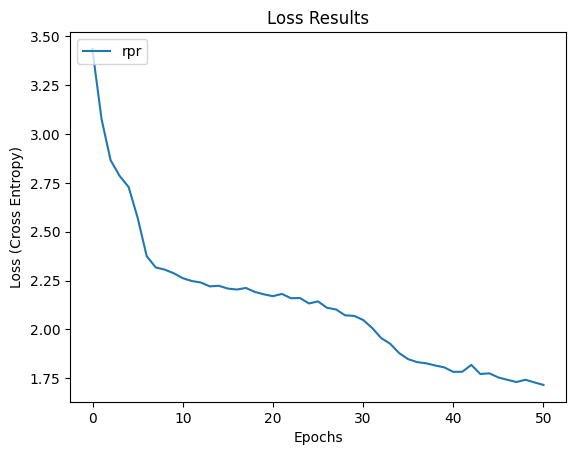

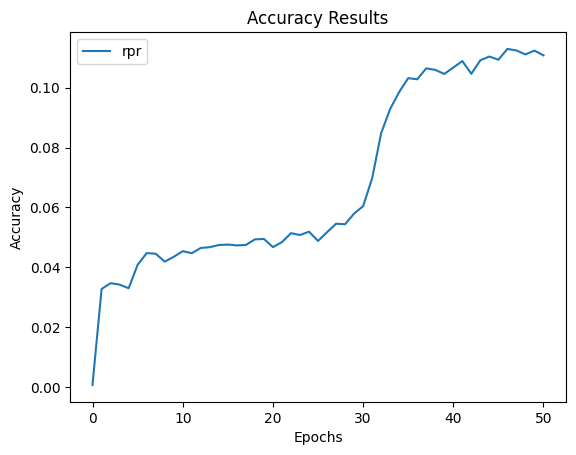

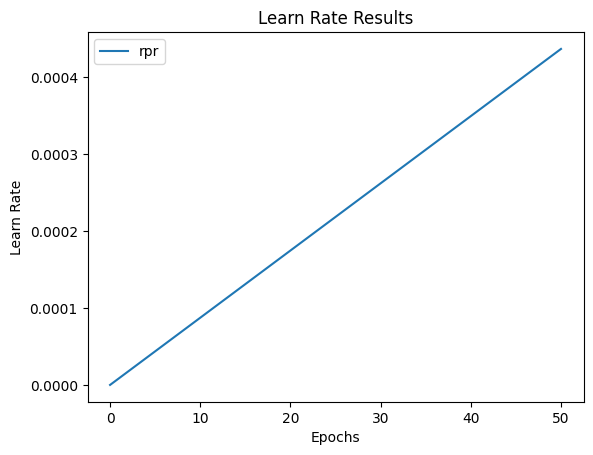

In [13]:
#@title Graph the results
import argparse
import os
import csv
import math
import matplotlib.pyplot as plt

RESULTS_FILE = "results.csv"
EPOCH_IDX = 0
LR_IDX = 1
EVAL_LOSS_IDX = 4
EVAL_ACC_IDX = 5

SPLITTER = '?'


def graph_results(input_dirs="/content/MusicTransformer-Pytorch/rpr/results", output_dir=None, model_names=None, epoch_start=0, epoch_end=None):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Graphs model training and evaluation data
    ----------
    """

    input_dirs = input_dirs.split(SPLITTER)

    if(model_names is not None):
        model_names = model_names.split(SPLITTER)
        if(len(model_names) != len(input_dirs)):
            print("Error: len(model_names) != len(input_dirs)")
            return

    #Initialize Loss and Accuracy arrays
    loss_arrs = []
    accuracy_arrs = []
    epoch_counts = []
    lrs = []

    for input_dir in input_dirs:
        loss_arr = []
        accuracy_arr = []
        epoch_count = []
        lr_arr = []

        f = os.path.join(input_dir, RESULTS_FILE)
        with open(f, "r") as i_stream:
            reader = csv.reader(i_stream)
            next(reader)

            lines = [line for line in reader]

        if(epoch_end is None):
            epoch_end = math.inf

        epoch_start = max(epoch_start, 0)
        epoch_start = min(epoch_start, epoch_end)

        for line in lines:
            epoch = line[EPOCH_IDX]
            lr = line[LR_IDX]
            accuracy = line[EVAL_ACC_IDX]
            loss = line[EVAL_LOSS_IDX]

            if(int(epoch) >= epoch_start and int(epoch) < epoch_end):
                accuracy_arr.append(float(accuracy))
                loss_arr.append(float(loss))
                epoch_count.append(int(epoch))
                lr_arr.append(float(lr))

        loss_arrs.append(loss_arr)
        accuracy_arrs.append(accuracy_arr)
        epoch_counts.append(epoch_count)
        lrs.append(lr_arr)

    if(output_dir is not None):
        try:
            os.mkdir(output_dir)
        except OSError:
            print ("Creation of the directory %s failed" % output_dir)
        else:
            print ("Successfully created the directory %s" % output_dir)

    ##### LOSS #####
    for i in range(len(loss_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], loss_arrs[i], label=name)
        plt.title("Loss Results")
        plt.ylabel('Loss (Cross Entropy)')
        plt.xlabel('Epochs')
        fig1 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig1.savefig(os.path.join(output_dir, 'loss_graph.png'))

    plt.show()

    ##### ACCURACY #####
    for i in range(len(accuracy_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], accuracy_arrs[i], label=name)
        plt.title("Accuracy Results")
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'accuracy_graph.png'))

    plt.show()

    ##### LR #####
    for i in range(len(lrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], lrs[i], label=name)
        plt.title("Learn Rate Results")
        plt.ylabel('Learn Rate')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'lr_graph.png'))

    plt.show()
graph_results('/content/MusicTransformer-Pytorch/rpr/results', model_names='rpr')

To have the model continue your custom MIDI enter the following into the custom_MIDI field below:

-primer_file '/content/some_dir/some_seed_midi.mid'

For example: -primer_file '/content/MusicTransformer-Pytorch/seed.mid'

# Generate and Explore the output :)

In [14]:
#@title Generate, Plot, Graph, Save, Download, and Render the resulting output
number_of_tokens_to_generate = 1023 #@param {type:"slider", min:1, max:2048, step:1}
priming_sequence_length = 65 #@param {type:"slider", min:1, max:2048, step:8}
maximum_possible_output_sequence = 2048 #@param {type:"slider", min:0, max:2048, step:8}
select_model = "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle" #@param ["/content/MusicTransformer-Pytorch/rpr/results/best_acc_weights.pickle", "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle"]
custom_MIDI = "" #@param {type:"string"}

import processor
from processor import encode_midi, decode_midi

!python generate.py -output_dir output -model_weights=$select_model --rpr -target_seq_length=$number_of_tokens_to_generate -num_prime=$priming_sequence_length -max_sequence=$maximum_possible_output_sequence $custom_MIDI #

print('Successfully exported the output to output folder. To primer.mid and rand.mid')

# set the src and play
FluidSynth("/content/font.sf2").midi_to_audio('/content/MusicTransformer-Pytorch/output/rand.mid', '/content/MusicTransformer-Pytorch/output/output.wav')

from google.colab import files
files.download('/content/MusicTransformer-Pytorch/output/rand.mid')
files.download('/content/MusicTransformer-Pytorch/output/primer.mid')

Audio('/content/MusicTransformer-Pytorch/output/output.wav')


midi_root: ./dataset/e_piano/
output_dir: output
primer_file: None
force_cpu: False

target_seq_length: 1023
num_prime: 65
model_weights: /content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle
beam: 0

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Using primer index: 12 ( ./dataset/e_piano/test/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--8.midi.pickle )
/content/MusicTransformer-Pytorch/generate.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects wi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
#@title Plot and Graph the Output :)
graphs_length_inches = 18 #@param {type:"slider", min:0, max:20, step:1}
notes_graph_height = 6 #@param {type:"slider", min:0, max:20, step:1}
highest_displayed_pitch = 92 #@param {type:"slider", min:1, max:128, step:1}
lowest_displayed_pitch = 24 #@param {type:"slider", min:1, max:128, step:1}
piano_roll_color_map = "Blues"

import librosa
import numpy as np
import pretty_midi
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
# For plotting
import mir_eval.display
import librosa.display
%matplotlib inline


midi_data = pretty_midi.PrettyMIDI('/content/MusicTransformer-Pytorch/output/rand.mid')

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))



roll = np.zeros([int(graphs_length_inches), 128])
# Plot the output

track = Multitrack('/content/MusicTransformer-Pytorch/output/rand.mid', name='track')
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
fig, ax = track.plot()
fig.set_size_inches(graphs_length_inches, notes_graph_height)
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
ax2 = plot_piano_roll(midi_data, int(lowest_displayed_pitch), int(highest_displayed_pitch))
plt.show(block=False)

ImportError: cannot import name 'BrokenBarHCollection' from 'matplotlib.collections' (/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py)

### Save to Google Drive (Standard GD connect code)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')